In [35]:
import pandas as pd
from pathlib import Path
from dyeles.ml import SimplePredictor
from dyeles import DyeLeS
from tqdm import tqdm  # 新增！用来显示进度条
from rdkit import Chem
from rdkit.Chem import Draw
import random
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image

In [11]:
data_dir = Path("../data")
target_num = 1000
predictor = SimplePredictor("../dyeles/resources/lightgbm.pkl")
scorer = DyeLeS()

# 数据源
chembl_data_path = data_dir / "chembl" / "chembl_35_chemreps.txt"

2025-04-22 12:52:19.792 | INFO     | dyeles.ml:load_model:26 - Loading the trained model from ../dyeles/resources/lightgbm.pkl...


In [20]:
# 采样初始化
collected = []
total_collected = 0

# 无限循环直到采满
with tqdm(total=target_num, desc="Collecting valid samples") as pbar:
    while total_collected < target_num:
        df_iter = pd.read_csv(chembl_data_path, sep="\t", chunksize=1000)

        for chunk in df_iter:
            # 过滤掉空的 smiles
            chunk = chunk.dropna(subset=["canonical_smiles"])
            chunk = chunk[chunk["canonical_smiles"].str.strip() != ""]

            if chunk.empty:
                continue  # 如果全是空的直接跳过

            smiles_list = chunk["canonical_smiles"].tolist()

            try:
                predictions = predictor.predict(smiles_list)
            except Exception as e:
                print(f"Prediction error: {e}")
                continue

            predictions_df = pd.DataFrame(
                predictions,
                columns=["absorption", "emission", "stokes_shift", "quantum_yield"]
            )
            scores = scorer(smiles_list)
            scores_df = pd.DataFrame(scores, columns=["score"])

            assert len(scores) == len(smiles_list) == len(predictions_df) == len(chunk), f"数据长度不一致 {len(scores)} != {len(smiles_list)} != {len(predictions_df)} != {len(chunk)}"

            combined = pd.concat([chunk.reset_index(drop=True), predictions_df, scores_df], axis=1)

            # 筛选符合要求的
            combined = combined[(combined["stokes_shift"] > 76) & (combined["quantum_yield"] > 0.34) & (combined["score"] > 0.5)]

            collected.append(combined)

            total_collected += len(combined)
            pbar.update(len(combined))

            if total_collected >= target_num:
                break
# 合并所有采样的数据
final_result = pd.concat(collected, ignore_index=True)

# 截断到正好 target_num
final_result = final_result.iloc[:target_num]

Scoring molecules: 100%|██████████| 1000/1000 [00:00<00:00, 3055.58it/s]


In [21]:
final_result

,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key,absorption,emission,stokes_shift,quantum_yield,score
0,CHEMBL383917,Cc1c(N2CC[C@@H]([C@H](C)N)C2)c(F)cc2c(=O)n(N)c...,InChI=1S/C18H24FN5O2/c1-9-15-13(17(25)24(21)18...,SMONLCFJGCJROJ-WDEREUQCSA-N,373.651419,457.110878,110.453050,0.455277,0.563148
1,CHEMBL500062,CC(=O)OCO/N=[N+](\[O-])N1CCC[C@H]1C(=O)OCc1ccc...,InChI=1S/C25H25F3N6O8S/c1-16(35)41-15-42-31-34...,WICOHTJHTHQKDJ-HKMMODACSA-N,444.862255,556.210815,93.788238,0.370972,0.944063
2,CHEMBL504187,NC[C@@H]1O[C@H](O[C@H]2[C@@H](O)[C@H](O[C@@H]3...,InChI=1S/C45H69FN12O16/c46-22-9-20-25(58(19-1-...,XECMDKMDAJGDJW-CTSKMVFLSA-N,475.220587,553.327009,94.867254,0.360423,1.190708
3,CHEMBL503623,Cc1cc2c(c(=O)[nH]1)C(=O)O/C2=C\c1cc2ccccc2s1,InChI=1S/C17H11NO3S/c1-9-6-12-13(21-17(20)15(1...,ZHWHAEPCMQSHKU-JYRVWZFOSA-N,424.228647,523.857174,79.212065,0.346778,0.692005
4,CHEMBL4116121,CN(C/C=C/c1cccc(F)c1)Cc1cccc2cc[nH]c12,InChI=1S/C19H19FN2/c1-22(12-4-6-15-5-2-9-18(20...,OBXMBBUJDPNURD-GQCTYLIASA-N,371.674692,489.881353,79.159928,0.351339,1.381433
...,...,...,...,...,...,...,...,...,...
995,CHEMBL37301,O=C(O)CCN1CCN(CCOC(c2ccc(F)cc2)c2ccc(F)cc2)CC1,InChI=1S/C22H26F2N2O3/c23-19-5-1-17(2-6-19)22(...,JCHVAKQKAGSFIQ-UHFFFAOYSA-N,343.255925,437.199055,81.687526,0.369410,0.799356
996,CHEMBL37310,CCN(CC)CCCOC(=O)c1ccccc1-c1ccccc1,InChI=1S/C20H25NO2/c1-3-21(4-2)15-10-16-23-20(...,RZOABFIAHQHUTG-UHFFFAOYSA-N,393.765570,431.830405,83.341441,0.354302,0.511108
997,CHEMBL37233,CCCC[n+]1cccc(/C=C/c2nc3cc(C)c(C)cc3[nH]2)c1.[I-],InChI=1S/C20H24N3.HI/c1-4-5-10-23-11-6-7-17(14...,UVZHRMLHVNVFGX-HRNDJLQDSA-M,416.065343,551.532296,77.101822,0.349720,0.887867
998,CHEMBL37234,CCOP(=O)(OCC)c1ccc(-c2nc3ccccc3s2)cc1,"InChI=1S/C17H18NO3PS/c1-3-20-22(19,21-4-2)14-1...",YIVBDRZZAKBHEG-UHFFFAOYSA-N,363.450805,465.161544,111.372517,0.524179,0.889864


In [22]:
final_result.to_csv("screen_result.csv", index=False)

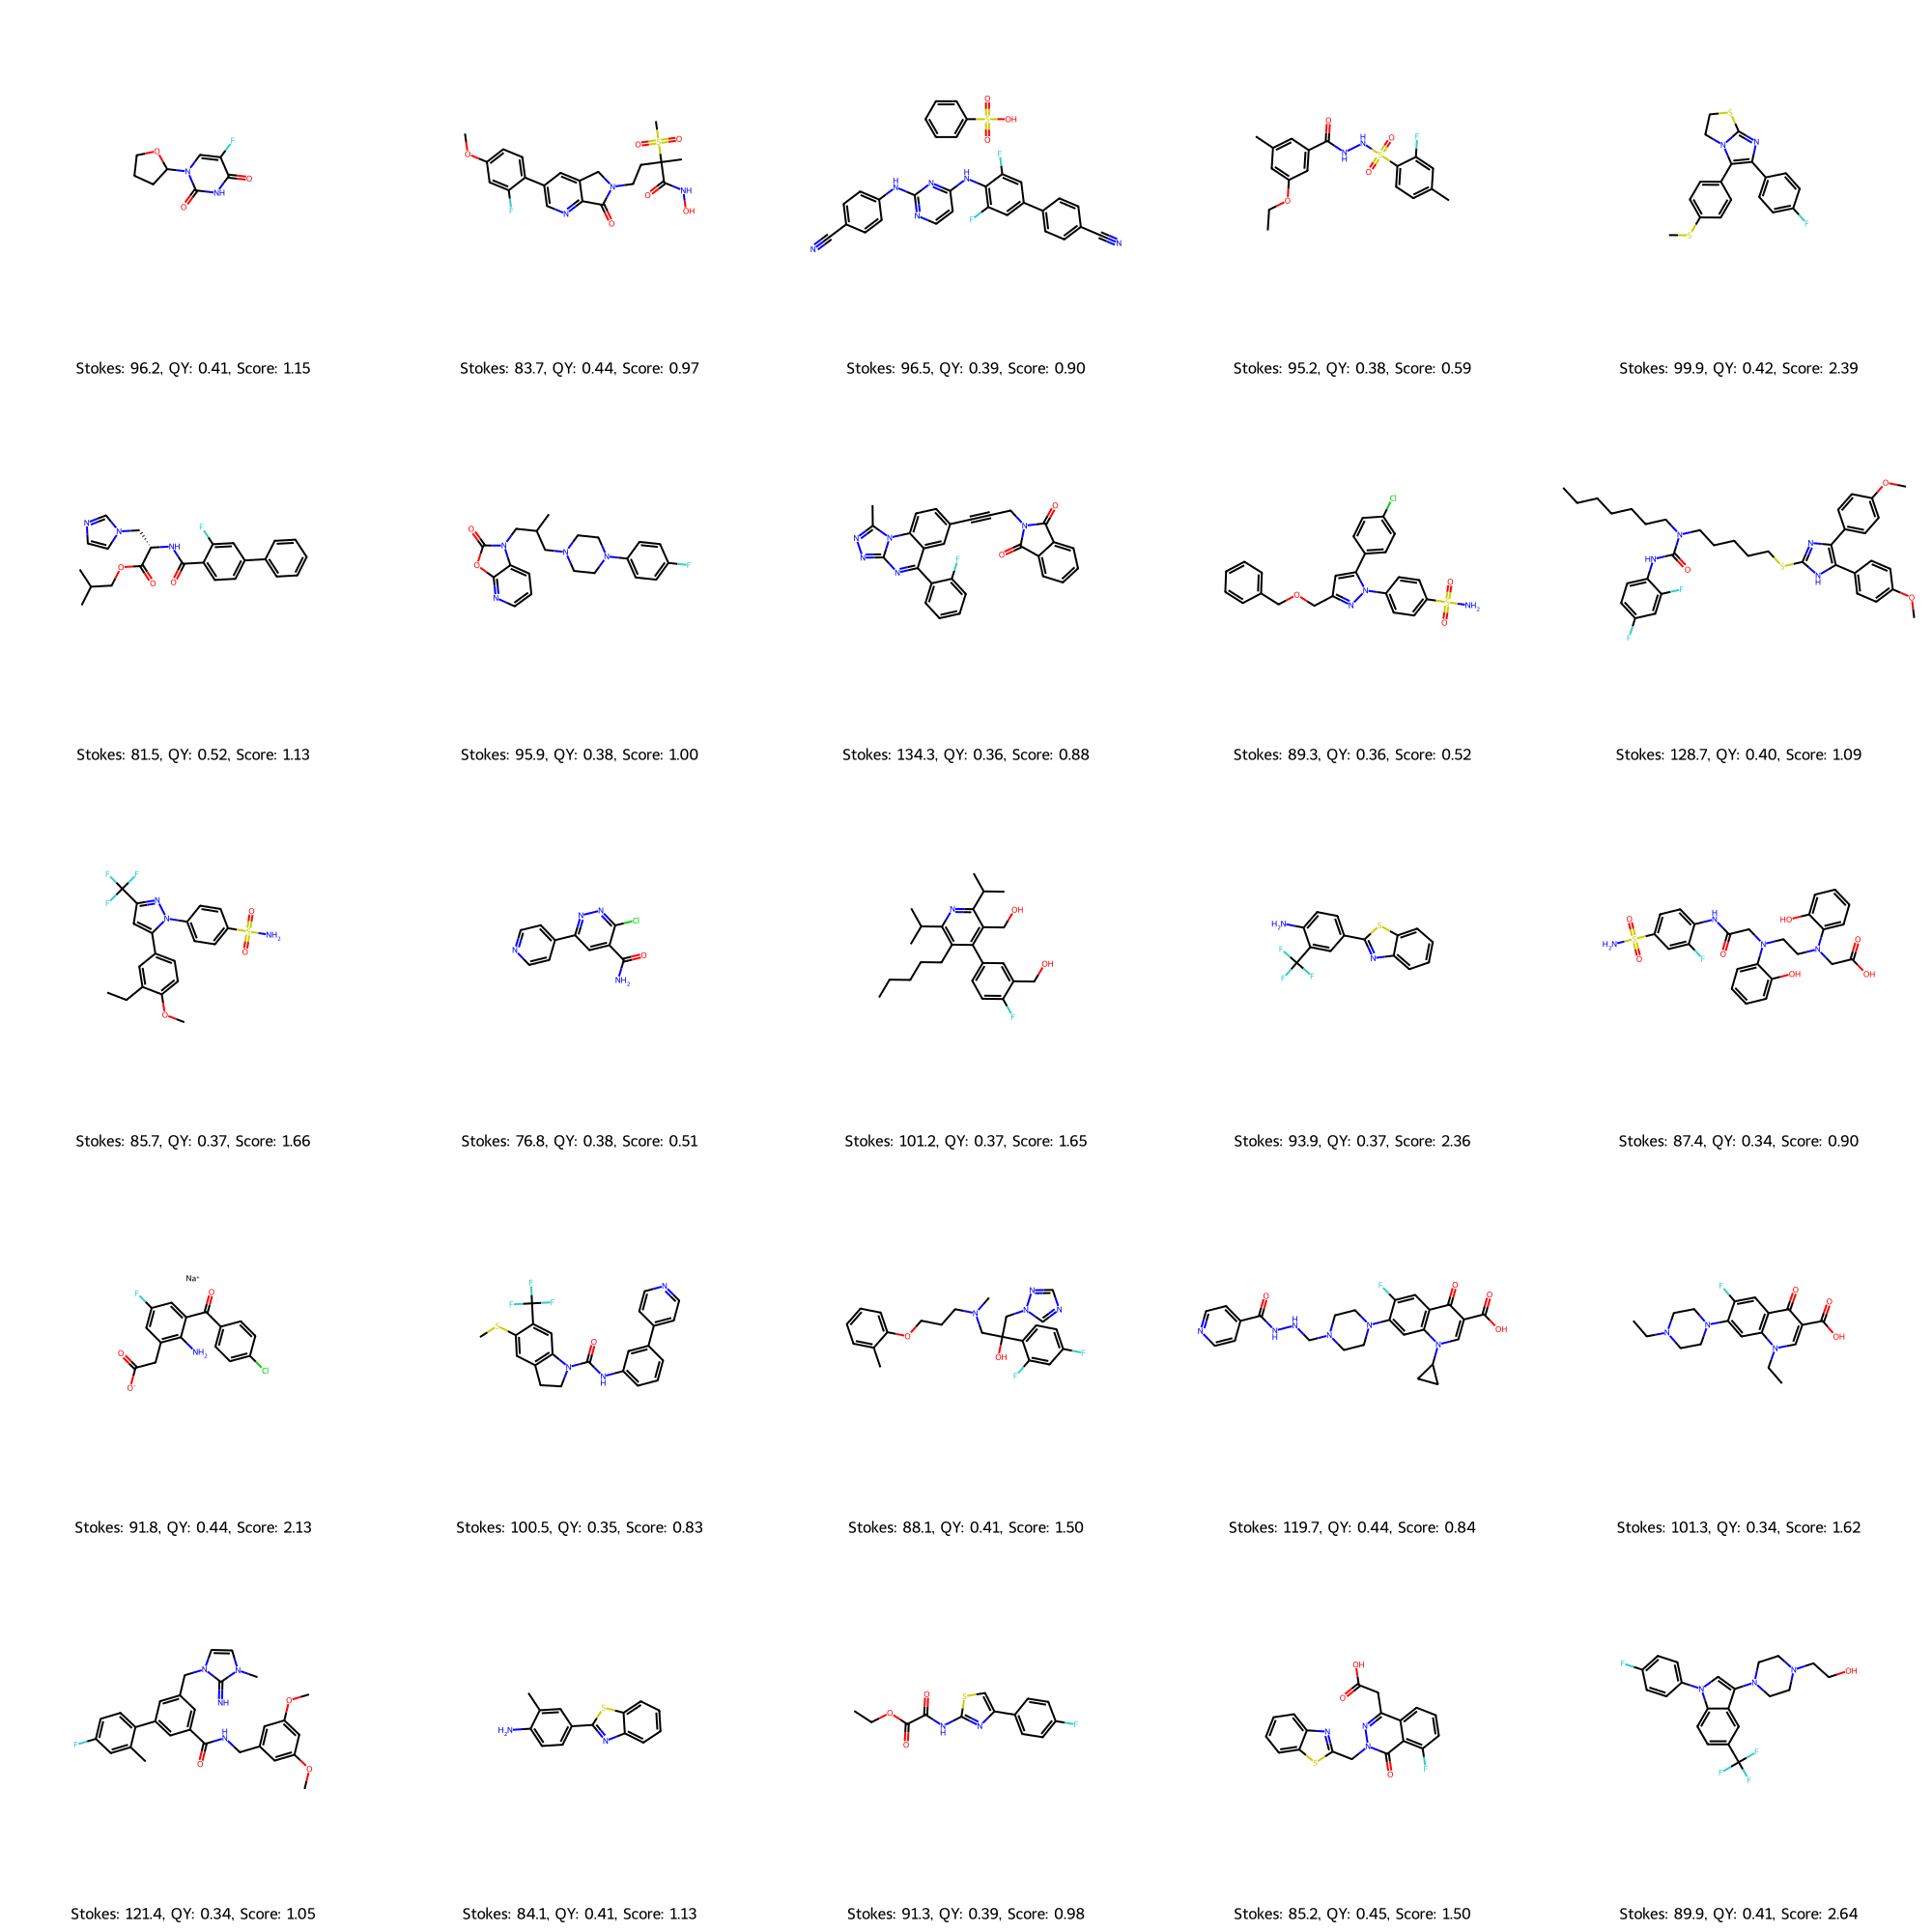

In [44]:
# ====== 参数 ======
target_valid_mols = 25  # 需要25个合法分子
per_mol_size = (400, 400)  # 每个小图的大小
grid_cols = 5  # 每行5个
random_seed = 42

# ====== 采样  ======
# 假设你的原始DataFrame叫 final_result
sampled_mols = []
sampled_legends = []

# 先打乱整个数据
shuffled_df = final_result.sample(frac=1, random_state=random_seed).reset_index(drop=True)

for idx, row in shuffled_df.iterrows():
    smiles = row["canonical_smiles"]
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        sampled_mols.append(mol)
        legend = f"Stokes: {row['stokes_shift']:.1f}, QY: {row['quantum_yield']:.2f}, Score: {row['score']:.2f}"
        sampled_legends.append(legend)
    if len(sampled_mols) >= target_valid_mols:
        break

# 最终确认数量
assert len(sampled_mols) == target_valid_mols, f"只找到 {len(sampled_mols)} 个有效分子，目标是 {target_valid_mols}！"

# ====== 画图 ======
grid_rows = (target_valid_mols + grid_cols - 1) // grid_cols  # 自动算行数
drawer = rdMolDraw2D.MolDraw2DCairo(
    grid_cols * per_mol_size[0],
    grid_rows * per_mol_size[1],
    per_mol_size[0],
    per_mol_size[1]
)

drawer.DrawMolecules(
    sampled_mols,
    legends=sampled_legends
)

drawer.FinishDrawing()

# 保存+显示
img_data = drawer.GetDrawingText()
Image(img_data)

2025-04-22 13:13:22.536 | INFO     | dyeles.ml:load_model:26 - Loading the trained model from ../dyeles/resources/lightgbm.pkl...
Processing ChEMBL dataset: 0it [00:00, ?it/s]2025-04-22 13:13:22.558 | INFO     | dyeles.ml:predict:33 - Predicting for 1000 SMILES.
Scoring molecules: 100%|██████████| 1000/1000 [00:00<00:00, 1271.80it/s]
Processing ChEMBL dataset: 1000it [00:02, 370.08it/s]2025-04-22 13:13:25.254 | INFO     | dyeles.ml:predict:33 - Predicting for 1000 SMILES.
Scoring molecules: 100%|██████████| 1000/1000 [00:00<00:00, 1247.27it/s]
Processing ChEMBL dataset: 2000it [00:05, 369.95it/s]2025-04-22 13:13:27.956 | INFO     | dyeles.ml:predict:33 - Predicting for 1000 SMILES.
Scoring molecules: 100%|██████████| 1000/1000 [00:00<00:00, 1171.49it/s]
Processing ChEMBL dataset: 3000it [00:08, 365.57it/s]2025-04-22 13:13:30.731 | INFO     | dyeles.ml:predict:33 - Predicting for 1000 SMILES.
Scoring molecules: 100%|██████████| 1000/1000 [00:00<00:00, 2295.91it/s]
Processing ChEMBL data

KeyboardInterrupt: 